In [ ]:
Install the necessary packages

In [ ]:
!sudo apt-get install python3.12

In [ ]:
!whereis python3.12

In [ ]:
!sudo update-alternatives --install /usr/bin/python3 python3 /usr/bin/python3.12 1

In [ ]:
!pip install -q condacolab
import condacolab
condacolab.install()
!conda --version
!conda create --name myenv python=3.12
!conda init
!conda activate myenv

In [ ]:
!conda install pytorch torchvision torchaudio pytorch-cuda=12.1 -c pytorch -c nvidia

In [ ]:
!pip install --upgrade tensorflow
!pip install --upgrade 'tf-keras>2.16'
!pip install --upgrade transformers
!pip install --upgrade spacy_transformers
!pip install --upgrade sklearn matplotlib spacy

In [1]:
!pip install alibi
!pip install sentencepiece
!pip install imblearn
!pip install --upgrade torch torchvision torchaudio transformers torchtext

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 522.1/522.1 kB 6.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 8.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.5/98.5 MB 7.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 779.1/779.1 MB 1.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.0/7.0 MB 59.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.3/3.3 MB 49.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 67.4 MB/s eta 0:00:00
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  U

In [ ]:
# imports are always needed
import torch


# get index of currently selected device
print(torch.cuda.current_device()) # returns 0 in my case


# get number of GPUs available
print(torch.cuda.device_count()) # returns 1 in my case


# get the name of the device
print(torch.cuda.get_device_name(0)) # good old Tesla

print(torch.version.cuda)



0
1
Tesla T4
12.1


Import the necessary packages

In [2]:
import os
import spacy
import random
import pandas as pd
import numpy as np
from scipy.special import softmax
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split, KFold, StratifiedKFold
from sklearn.manifold import TSNE
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier
from sklearn.dummy import DummyClassifier
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
from imblearn.over_sampling import RandomOverSampler
import tensorflow as tf
import torch
from torch.utils.data import DataLoader, TensorDataset
import torch.nn.functional as F
import torch.nn as nn
from torch.optim import AdamW, SGD
from transformers import RobertaTokenizer, RobertaForSequenceClassification, AutoTokenizer, AutoModel, pipeline
from alibi.explainers import AnchorText

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Set the random seed for reproducibility

In [ ]:
# set seed, TF uses python ramdom and numpy library, so these must also be fixed
#tf.random.set_seed(0)
random.seed(0)
np.random.seed(0)
os.environ['PYTHONHASHSEED']=str(0)
os.environ['TF_DETERMINISTIC_OPS'] = '0'

In [4]:
df1 = pd.read_excel('/content/drive/MyDrive/final_labels_SG1.xlsx')
df2 = pd.read_excel('/content/drive/MyDrive/final_labels_SG2.xlsx')

In [ ]:
df1.head()

,text,news_link,outlet,topic,type,label_bias,label_opinion,biased_words
0,The Republican president assumed he was helpin...,http://www.msnbc.com/rachel-maddow-show/auto-i...,msnbc,environment,left,Biased,Expresses writer’s opinion,[]
1,Though the indictment of a woman for her own p...,https://eu.usatoday.com/story/news/nation/2019...,usa-today,abortion,center,Non-biased,Somewhat factual but also opinionated,[]
2,Ingraham began the exchange by noting American...,https://www.breitbart.com/economy/2020/01/12/d...,breitbart,immigration,right,No agreement,No agreement,['flood']
3,The tragedy of America’s 18 years in Afghanist...,http://feedproxy.google.com/~r/breitbart/~3/ER...,breitbart,international-politics-and-world-news,right,Biased,Somewhat factual but also opinionated,"['tragedy', 'stubborn']"
4,The justices threw out a challenge from gun ri...,https://www.huffpost.com/entry/supreme-court-g...,msnbc,gun-control,left,Non-biased,Entirely factual,[]


In [ ]:
df2.head()

,text,news_link,outlet,topic,type,label_bias,label_opinion,biased_words
0,"""Orange Is the New Black"" star Yael Stone is r...",https://www.foxnews.com/entertainment/australi...,Fox News,environment,right,Non-biased,Entirely factual,[]
1,"""We have one beautiful law,"" Trump recently sa...",https://www.alternet.org/2020/06/law-and-order...,Alternet,gun control,left,Biased,Somewhat factual but also opinionated,"['bizarre', 'characteristically']"
2,"...immigrants as criminals and eugenics, all o...",https://www.nbcnews.com/news/latino/after-step...,MSNBC,white-nationalism,left,Biased,Expresses writer’s opinion,"['criminals', 'fringe', 'extreme']"
3,...we sounded the alarm in the early months of...,https://www.alternet.org/2019/07/fox-news-has-...,Alternet,white-nationalism,left,Biased,Somewhat factual but also opinionated,[]
4,[Black Lives Matter] is essentially a non-fals...,http://feedproxy.google.com/~r/breitbart/~3/-v...,Breitbart,marriage-equality,NaN,Biased,Expresses writer’s opinion,['cult']


Preprocess the data, remove rows with no agreement and convert the labels to binary

In [5]:
df1 = df1[df1['label_bias']!='No agreement']
df1.replace(to_replace='Biased', value=1, inplace=True)
df1.replace(to_replace='Non-biased', value=0, inplace=True)

<ipython-input-5-63335be02dd0>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df1.replace(to_replace='Biased', value=1, inplace=True)
<ipython-input-5-63335be02dd0>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df1.replace(to_replace='Non-biased', value=0, inplace=True)


In [6]:
df2 = df2[df2['label_bias']!='No agreement']
df2.replace(to_replace='Biased', value=1, inplace=True)
df2.replace(to_replace='Non-biased', value=0, inplace=True)

Define the stratified k-fold instance

In [ ]:
# Stratified k-Fold instance
skfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

Define the functions to be used in the skfold loop. These functions are used to convert the pandas dataframe into a tensorflow dataset, plot the training history, plot the confusion matrix, and tokenize the data for the transformer model.

In [8]:
# helper functions called in skfold loop

def pd_to_tf(df):
    """convert a pandas dataframe into a tensorflow dataset"""
    target = df.pop('label_bias')
    sentence = df.pop('text')
    return tf.data.Dataset.from_tensor_slices((sentence.values, target.values))

def plot_graphs(history, metric, filename):
  plt.plot(history.history[metric])
  plt.plot(history.history['val_'+metric], '')
  plt.xlabel("Epochs")
  plt.ylabel(metric)
  plt.legend([metric, 'val_'+metric])
  plt.savefig(filename)
  plt.show()

def plot_confusion_matrix(y_true, y_pred, classes, filename):
    """Plots a confusion matrix as a heatmap and saves it as a PNG file."""
    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)

    fig, ax = plt.subplots()
    # Create a heatmap from the confusion matrix
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=ax, cbar=False)

    # Set labels and title
    ax.set_xlabel('Predicted labels')
    ax.set_ylabel('True labels')
    ax.set_title('Confusion Matrix')
    ax.xaxis.set_ticklabels(classes)
    ax.yaxis.set_ticklabels(classes)

    # Save the figure
    plt.savefig(filename)
    plt.show()

def tokenize(df):
    """convert a pandas dataframe into a tensorflow dataset and run hugging face's tokenizer on data"""
    target = df.pop('label_bias')
    sentence = df.pop('text')

    train_encodings = tokenizer(
                        sentence.tolist(),
                        add_special_tokens = True, # add [CLS], [SEP]
                        truncation = True, # cut off at max length of the text that can go to BERT
                        padding = True, # add [PAD] tokens
                        return_attention_mask = True, # add attention mask to not focus on pad tokens
              )

    dataset = tf.data.Dataset.from_tensor_slices(
        (dict(train_encodings),
         target.tolist()))
    return dataset


class CustomModel(nn.Module):
    def __init__(self, base_model, num_labels):
        super(CustomModel, self).__init__()
        self.base_model = base_model

        # Define the first layer
        self.fc1 = nn.Linear(2, 256)

        # Define the second layer
        self.fc2 = nn.Linear(256, 256)

        # Define the last layer
        self.fc3 = nn.Linear(256, 2)
        self.num_labels = num_labels

    def forward(self, input_ids, attention_mask, labels=None):
        outputs = self.base_model(input_ids=input_ids, attention_mask=attention_mask)
        x = self.fc1(outputs.logits)
        x = torch.relu(x)  # Apply ReLU activation function

        # Pass through the second layer
        x = self.fc2(x)
        x = torch.relu(x)  # Apply ReLU activation function

        # Pass through the last layer
        x = self.fc3(x)
        logits = x

        loss = None
        if labels is not None:
            loss_fct = nn.CrossEntropyLoss()
            loss = loss_fct(logits.view(-1, self.num_labels), labels.view(-1))

        return logits, loss


Define the function to run the model. This function takes in the training data, the name of the file, and the flags to freeze the encoder layer and use pretrained weights. It returns the validation loss, accuracy, precision, recall, f1 score, micro f1 score, and weighted macro f1 score. The run_model_5fold function is similar to the run_model function, but it uses a 5-fold cross-validation instead of a single validation set.
The first two models are the original code with tensorflow framework.

In [ ]:
def run_model(df_train, named_file, freeze_encoder=True, pretrained=False, plot=False):
  """"freeze flags whether encoder layer should be frozen to not destroy transfer learning. Only set to false when enough data is provided"""
#
  Y = df_train['label_bias']
  X = df_train['text']

  # hyperparams
  BUFFER_SIZE = 10000
  BATCH_SIZE = 16
  epochs = 40

  # Split the data into training and testing sets
  X_train, X_val, y_train, y_val = train_test_split(X, Y, test_size=0.2, random_state=42)

  train_dataset = pd.concat([X_train, y_train], axis=1)
  val_dataset = pd.concat([X_val, y_val], axis=1)

  ros = RandomOverSampler(random_state=0)
  X_resampled, y_resampled = ros.fit_resample(pd.DataFrame(train_dataset['text']), pd.DataFrame(train_dataset['label_bias']))

  # Replace the original training dataset with the resampled dataset
  train_dataset = pd.concat([pd.DataFrame(X_resampled), pd.DataFrame(y_resampled)], axis=1)
  train_dataset.columns = ['text', 'label_bias']
  # prepare data for transformer
  train_dataset = tokenize(train_dataset)
  val_dataset = tokenize(val_dataset)

  # mini-batch it
  train_dataset = train_dataset.shuffle(BUFFER_SIZE).batch(BATCH_SIZE).prefetch(tf.data.experimental.AUTOTUNE)
  val_dataset = val_dataset.batch(BATCH_SIZE).prefetch(tf.data.experimental.AUTOTUNE)

  # create new model
  model = TFRobertaForSequenceClassification.from_pretrained('FacebookAI/roberta-base')

  if freeze_encoder == True:
    for w in model.get_layer(index=0).weights:
      w._trainable = False

  # compile it
  loss_function = tf.keras.losses.BinaryCrossentropy(from_logits=False)
  optimizer, lr_schedule = create_optimizer(
  init_lr=2e-5, num_warmup_steps=0,
  num_train_steps=len(train_dataset) // BATCH_SIZE * epochs)
  model.compile(optimizer=optimizer, loss=loss_function)

  # transfer learning
  if pretrained == True:
    model.get_layer(index=0).set_weights(trained_model_layer) # load bias-specific weights

  # fit it
  history = model.fit(train_dataset, epochs=20, validation_data = val_dataset)

  # save the fine-tuned model
  model.save_weights(f'{named_file}_Roberta_fine_tuned.h5')

  # plot history
  if plot:
    plot_graphs(history,'loss', named_file+'_loss')
    #plot_graphs(history,'accuracy', named_file+'_accuracy')

  # evaluate
  loss = model.evaluate(val_dataset)

  logits = model.predict(val_dataset)
  yhats = []
  for i in logits[0]:
    # assign class label according to highest logit
    candidates = i.tolist()
    decision = candidates.index(max(candidates))
    yhats.append(decision)

  y = []
  for text, label in val_dataset.unbatch():
    y.append(label.numpy())

  # Plot and save the confusion matrix
  plot_confusion_matrix(y, yhats, ['Non-biased', 'Biased'], f'{named_file}_confusion_matrix.png')

  val_loss = loss
  val_acc = accuracy_score(y, yhats)
  val_prec = precision_score(y, yhats)
  val_rec = recall_score(y, yhats)
  val_f1 = f1_score(y, yhats)
  val_f1_micro = f1_score(y, yhats, average='micro')
  val_f1_wmacro = f1_score(y, yhats, average='weighted')

  tf.keras.backend.clear_session()

  return val_loss, val_acc, val_prec, val_rec, val_f1, val_f1_micro, val_f1_wmacro


In [ ]:
def run_model_5fold(df_train, named_file, freeze_encoder=True, pretrained=False, plot=False):
  """"freeze flags whether encoder layer should be frozen to not destroy transfer learning. Only set to false when enough data is provided"""

  # these variables will be needed for skfold to select indices
  Y = df_train['label_bias']
  X = df_train['text']

  # hyperparams
  BUFFER_SIZE = 10000
  BATCH_SIZE = 32
  epochs = 40
  k = 1

  val_loss = []
  val_acc = []
  val_prec = []
  val_rec = []
  val_f1 = []
  val_f1_micro = []
  val_f1_wmacro = []


  for train_index, val_index in skfold.split(X,Y):
    print('### Start fold {}'.format(k))

    # split into train and validation set
    train_dataset = df_train.iloc[train_index]
    val_dataset = df_train.iloc[val_index]

    # Apply oversampling to the training dataset
    ros = RandomOverSampler(random_state=0)
    X_resampled, y_resampled = ros.fit_resample(pd.DataFrame(train_dataset['text']), pd.DataFrame(train_dataset['label_bias']))

    # Replace the original training dataset with the resampled dataset
    train_dataset = pd.concat([pd.DataFrame(X_resampled), pd.DataFrame(y_resampled)], axis=1)
    train_dataset.columns = ['text', 'label_bias']
    # prepare data for transformer
    train_dataset = tokenize(train_dataset)
    val_dataset = tokenize(val_dataset)

    # mini-batch it
    train_dataset = train_dataset.shuffle(BUFFER_SIZE).batch(BATCH_SIZE).prefetch(tf.data.experimental.AUTOTUNE)
    val_dataset = val_dataset.batch(BATCH_SIZE).prefetch(tf.data.experimental.AUTOTUNE)

    # create new model
    model = TFRobertaForSequenceClassification.from_pretrained('FacebookAI/roberta-base')


    if freeze_encoder == True:
      for w in model.get_layer(index=0).weights:
        w._trainable = False

    # compile it
    loss_function = tf.keras.losses.BinaryCrossentropy(from_logits=False)
    optimizer, lr_schedule = create_optimizer(
    init_lr=2e-5, num_warmup_steps=0,
    num_train_steps=len(train_dataset) // BATCH_SIZE * epochs)
    #optimizer = keras.optimizers.Adam(learning_rate=5e-5)
    model.compile(optimizer=optimizer, loss=loss_function)

    # transfer learning
    if pretrained == True:
      model.get_layer(index=0).set_weights(trained_model_layer) # load bias-specific weights

    # after 2 epochs without improvement, stop training
    # callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=True)

    # fit it
    #history = model.fit(train_dataset, epochs=100, validation_data = val_dataset, callbacks=[callback])
    history = model.fit(train_dataset, epochs=30, validation_data = val_dataset)

    # checkpointing
    #checkpoint = ModelCheckpoint(f'{model_name}_fine_tuned_fold_{k}_epoch_{epoch:02d}.h5', save_weights_only=True)
    #history = model.fit(train_dataset, epochs=10, validation_data = val_dataset, callbacks=[callback, checkpoint])


    # save the fine-tuned model
    model.save_weights(f'{named_file}_Roberta_fine_tuned_{k}.h5')

    # plot history
    if plot:
      plot_graphs(history,'loss', named_file+'_'+str(k)+'_fold_loss')
      #plot_graphs(history,'accuracy', named_file+'_'+str(k)+'_fold_accuracy')

    # evaluate
    loss = model.evaluate(val_dataset)

    logits = model.predict(val_dataset)
    yhats = []
    for i in logits[0]:
      # assign class label according to highest logit
      candidates = i.tolist()
      decision = candidates.index(max(candidates))
      yhats.append(decision)

    y = []
    for text, label in val_dataset.unbatch():
      y.append(label.numpy())

    # Plot and save the confusion matrix
    plot_confusion_matrix(y, yhats, ['Non-biased', 'Biased'], f'{named_file}_confusion_matrix_fold_{k}.png')

    val_loss.append(loss)
    val_acc.append(accuracy_score(y, yhats))
    val_prec.append(precision_score(y, yhats))
    val_rec.append(recall_score(y, yhats))
    val_f1.append(f1_score(y, yhats))
    val_f1_micro.append(f1_score(y, yhats, average='micro'))
    val_f1_wmacro.append(f1_score(y, yhats, average='weighted'))

    tf.keras.backend.clear_session()

    k += 1

  return val_loss, val_acc, val_prec, val_rec, val_f1, val_f1_micro, val_f1_wmacro


The following cell is the final implementation for the model, the model one only finetune the LLM

The results reported in my project report are extracted from pure LLM rather than my CustomModel.

In [ ]:
def run_model(df_train, named_file, freeze_encoder=True, pretrained=False, plot=False, init_type=None, learning_rate=1e-5):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    # Initialize the tokenizer and model
    model = RobertaForSequenceClassification.from_pretrained('FacebookAI/roberta-base')
    model = model.to(device)

    # Initialize weights based on the init_type
    def init_weights(m):
        if type(m) == torch.nn.Linear:
            if init_type == 'xavier':
                torch.nn.init.xavier_uniform_(m.weight)
            elif init_type == 'kaiming':
                torch.nn.init.kaiming_uniform_(m.weight)
            elif init_type == 'orthogonal':
                torch.nn.init.orthogonal_(m.weight)
            elif init_type == 'zero':
                torch.nn.init.zeros_(m.weight)
            m.bias.data.fill_(0.01)

    if init_type is not None:
        model.apply(init_weights)


    # Check if checkpoint exists and load it
    checkpoint_path = f'/content/drive/MyDrive/{named_file}_Roberta_fine_tuned_pure.pt'
    if os.path.exists(checkpoint_path):
        model.load_state_dict(torch.load(checkpoint_path, map_location=device))

    # with open('model_layers.txt', 'w') as f:
    #     for module in model.modules():
    #         f.write(f'Type: {type(module)}\n')

    if freeze_encoder:
        for param in model.base_model.parameters():
            param.requires_grad = False

    # Define the loss function and optimizer
    loss_function = torch.nn.CrossEntropyLoss()
    optimizer = AdamW(model.parameters(), lr=learning_rate)
    #optimizer = torch.optim.SGD(model.parameters(), momentum=0.9, lr=learning_rate)

    # Prepare the data
    X = df_train['text']
    y = df_train['label_bias']
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=23)
    #print(len(X_train))
    #print(len(X_test))
    X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=23) # Further split train set into train and validation
    #print(len(X_train))
    #print(len(X_val))

    # Apply oversampling to the training data
    oversampler = RandomOverSampler(random_state=42)
    X_train_resampled, y_train_resampled = oversampler.fit_resample(np.array(X_train).reshape(-1, 1), y_train)
    X_train_resampled = X_train_resampled.ravel().tolist()

    # Tokenize the data
    train_encodings = tokenizer(X_train_resampled, truncation=True, padding=True, add_special_tokens=True, return_attention_mask=True)
    val_encodings = tokenizer(X_val.tolist(), truncation=True, padding=True, add_special_tokens=True, return_attention_mask=True)
    test_encodings = tokenizer(X_test.tolist(), truncation=True, padding=True, add_special_tokens=True, return_attention_mask=True)

    train_dataset = TensorDataset(torch.tensor(train_encodings['input_ids']), torch.tensor(train_encodings['attention_mask']), torch.tensor(y_train_resampled))
    val_dataset = TensorDataset(torch.tensor(val_encodings['input_ids']), torch.tensor(val_encodings['attention_mask']), torch.tensor(y_val.tolist()))
    test_dataset = TensorDataset(torch.tensor(test_encodings['input_ids']), torch.tensor(test_encodings['attention_mask']), torch.tensor(y_test.tolist()))

    # Create data loaders tested 64, 16 but 8 is the best for learning stability
    train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
    test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)


    train_losses = []
    val_losses = []

    # Training loop
    best_val_loss = float('inf')
    for epoch in range(2):
        model.train()
        epoch_loss = 0
        for batch in train_loader:
            optimizer.zero_grad()
            input_ids = batch[0].to(device)
            attention_mask = batch[1].to(device)
            labels = batch[2].to(device).long()
            outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
            loss = outputs.loss
            loss.backward()

            optimizer.step()
            epoch_loss += loss.item()
        epoch_loss = epoch_loss / len(train_loader)
        train_losses.append(epoch_loss)
        print(f'Epoch {epoch+1}, Train Loss: {epoch_loss}')

        # Validation
        model.eval()
        val_loss = 0
        y_pred = []
        y_true = []
        with torch.no_grad():
            for batch in val_loader:
                input_ids = batch[0].to(device)
                attention_mask = batch[1].to(device)
                labels = batch[2].to(device).long()
                outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
                val_loss += loss_function(outputs.logits, labels).item()
                # Convert the logits to class labels
                _, preds = torch.max(outputs.logits, dim=1)
                y_pred.extend(preds.tolist())
                y_true.extend(labels.tolist())
        val_loss = val_loss / len(val_loader)
        val_losses.append(val_loss)
        print(f'Epoch {epoch+1}, Val Loss: {val_loss}')

        # Save the model if validation loss has decreased
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            torch.save(model.state_dict(), checkpoint_path)
    # Test
    model.eval()
    test_loss = 0
    y_pred_test = []
    y_true_test = []
    with torch.no_grad():
        for batch in test_loader:
            input_ids = batch[0].to(device)
            attention_mask = batch[1].to(device)
            labels = batch[2].to(device).long()
            outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
            test_loss += loss_function(outputs.logits, labels).item()
            # Convert the logits to class labels
            _, preds = torch.max(outputs.logits, dim=1)
            y_pred_test.extend(preds.tolist())
            y_true_test.extend(labels.tolist())
    test_loss = test_loss / len(test_loader)

    # calculate the metrics
    test_acc = accuracy_score(y_true_test, y_pred_test)
    test_prec = precision_score(y_true_test, y_pred_test, average='binary')
    test_rec = recall_score(y_true_test, y_pred_test, average='binary')
    test_f1 = f1_score(y_true_test, y_pred_test, average='binary')
    test_f1_micro = f1_score(y_true_test, y_pred_test, average='micro')
    test_f1_wmacro = f1_score(y_true_test, y_pred_test, average='weighted')

    # Plotting
    if plot:
        # Plot training and validation loss
        plt.figure(figsize=(10, 5))
        plt.plot(train_losses, label='Train Loss')
        plt.plot(val_losses, label='Val Loss')
        plt.title('Losses')
        plt.xlabel('Epochs')
        plt.ylabel('Loss')
        plt.legend()
        #plt.show()

    # Plot confusion matrix
    plot_confusion_matrix(y_true_test, y_pred_test, ['Non-biased', 'Biased'], f'{named_file}_confusion_matrix.png')

    return test_loss, test_acc, test_prec, test_rec, test_f1, test_f1_micro, test_f1_wmacro

In [ ]:
del run_model
torch.cuda.empty_cache()

In [ ]:
os.kill(os.getpid(), 9)

Now run the model in two forms on SG1.

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at FacebookAI/roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1, Train Loss: 0.06984652893510289
Epoch 1, Val Loss: 0.026927737199002877
Epoch 2, Train Loss: 0.03885957611133703
Epoch 2, Val Loss: 0.08961531583918259


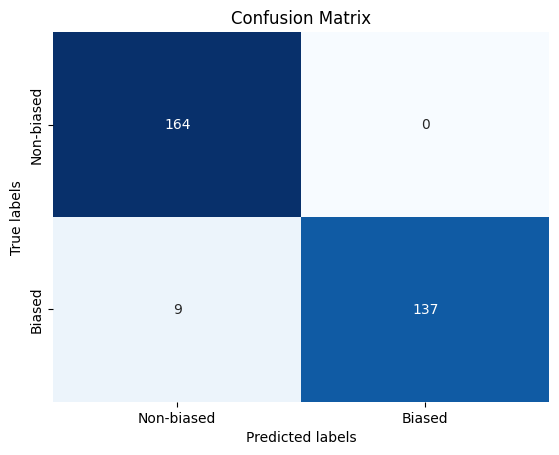

Results for Roberta on SG1
Test Loss: 0.08235172405838967
Test Accuracy: 0.9709677419354839
Test Precision: 1.0
Test Recall: 0.9383561643835616
Test F1 Score: 0.9681978798586572
Test Micro F1 Score: 0.9709677419354839
Test Weighted Macro F1 Score: 0.9708937693577644


In [ ]:
tokenizer = RobertaTokenizer.from_pretrained('FacebookAI/roberta-base')
test_loss, test_acc, test_prec, test_rec, test_f1, test_f1_micro, test_f1_wmacro = run_model(df1, named_file='df1',freeze_encoder=False, pretrained=False, plot=False, init_type=None, learning_rate=1e-5)

print('Results for Roberta on SG1')
print('Test Loss: {}'.format(test_loss))
print('Test Accuracy: {}'.format(test_acc))
print('Test Precision: {}'.format(test_prec))
print('Test Recall: {}'.format(test_rec))
print('Test F1 Score: {}'.format(test_f1))
print('Test Micro F1 Score: {}'.format(test_f1_micro))
print('Test Weighted Macro F1 Score: {}'.format(test_f1_wmacro))


### Start fold 1


model.safetensors:   0%|          | 0.00/499M [00:00<?, ?B/s]

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFRobertaForSequenceClassification: ['roberta.embeddings.position_ids']
- This IS expected if you are initializing TFRobertaForSequenceClassification from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFRobertaForSequenceClassification from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
Some weights or buffers of the TF 2.0 model TFRobertaForSequenceClassification were not initialized from the PyTorch model and are newly initialized: ['classifier.dense.weight', 'classifier.dense.bias', 'classifier.out_proj.weight', 'classifier.out_proj.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predicti

Epoch 1/30


Cause: for/else statement not yet supported
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Cause: for/else statement not yet supported
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
40/40 [==============================] - 141s 720ms/step - loss: 1.4861 - val_loss: 0.7458
Epoch 2/30
40/40 [==============================] - 14s 345ms/step - loss: 0.8040 - val_loss: 0.7458
Epoch 3/30
40/40 [==============================] - 13s 323ms/step - loss: 0.8006 - val_loss: 0.7458
Epoch 4/30
40/40 [==============================] - 13s 319ms/step - loss: 0.7903 - val_loss: 0.7458
Epoch 5/30
40/40 [==============================] - 12s 309ms/step - loss: 0.7903 - val_loss: 0.7458
Epoch 6/30
40/40 [==============================] - 12s 298ms/step - loss: 0.8023 - val_loss: 0.7458
Epoch 7/30
40/40 [==============================] - 12s 301ms/step - loss: 0.8096 - val_loss: 0.7458
Epoch 8/30
40/40 [==============================] - 12s 300ms/step - loss: 0.8083 - val_loss: 0.7458
Epoch 9/30
40/40 [==============================] - 12s 297ms/st

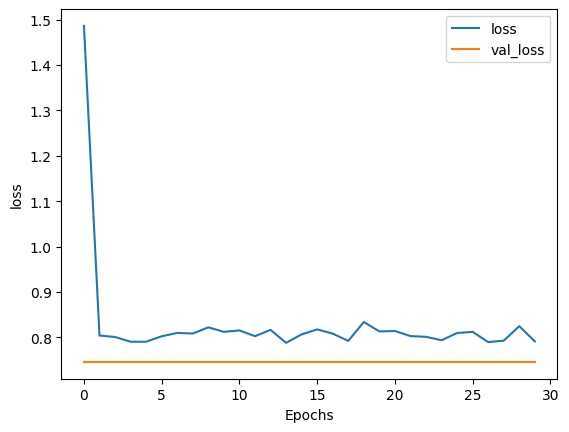

10/10 [==============================] - 12s 79ms/step


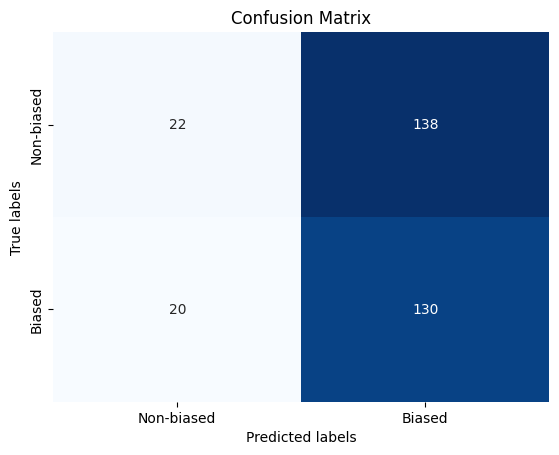

### Start fold 2


Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFRobertaForSequenceClassification: ['roberta.embeddings.position_ids']
- This IS expected if you are initializing TFRobertaForSequenceClassification from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFRobertaForSequenceClassification from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
Some weights or buffers of the TF 2.0 model TFRobertaForSequenceClassification were not initialized from the PyTorch model and are newly initialized: ['classifier.dense.weight', 'classifier.dense.bias', 'classifier.out_proj.weight', 'classifier.out_proj.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predicti

Epoch 1/30
40/40 [==============================] - 101s 708ms/step - loss: 0.9723 - val_loss: 0.6636
Epoch 2/30
40/40 [==============================] - 13s 329ms/step - loss: 0.7174 - val_loss: 0.6636
Epoch 3/30
40/40 [==============================] - 12s 313ms/step - loss: 0.7168 - val_loss: 0.6636
Epoch 4/30
40/40 [==============================] - 13s 312ms/step - loss: 0.7216 - val_loss: 0.6636
Epoch 5/30
40/40 [==============================] - 12s 310ms/step - loss: 0.7163 - val_loss: 0.6636
Epoch 6/30
40/40 [==============================] - 13s 317ms/step - loss: 0.7271 - val_loss: 0.6636
Epoch 7/30
40/40 [==============================] - 12s 310ms/step - loss: 0.7208 - val_loss: 0.6636
Epoch 8/30
40/40 [==============================] - 12s 307ms/step - loss: 0.7026 - val_loss: 0.6636
Epoch 9/30
40/40 [==============================] - 12s 297ms/step - loss: 0.7167 - val_loss: 0.6636
Epoch 10/30
40/40 [==============================] - 12s 303ms/step - loss: 0.7060 - val_l

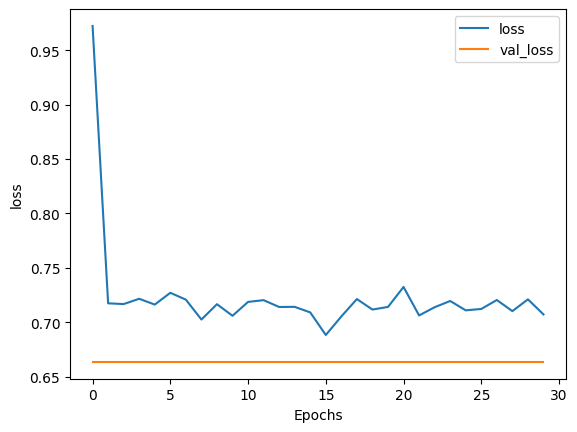

10/10 [==============================] - 12s 97ms/step


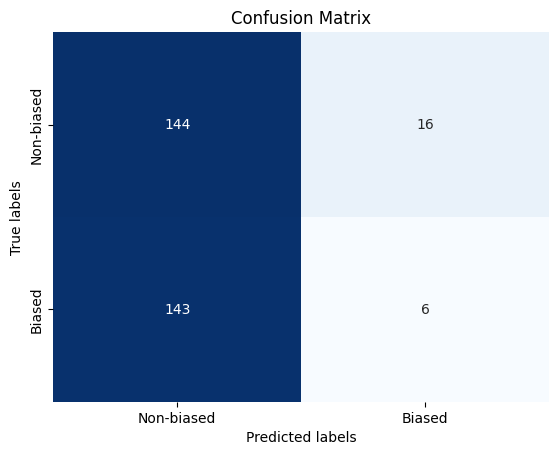

### Start fold 3


Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFRobertaForSequenceClassification: ['roberta.embeddings.position_ids']
- This IS expected if you are initializing TFRobertaForSequenceClassification from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFRobertaForSequenceClassification from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
Some weights or buffers of the TF 2.0 model TFRobertaForSequenceClassification were not initialized from the PyTorch model and are newly initialized: ['classifier.dense.weight', 'classifier.dense.bias', 'classifier.out_proj.weight', 'classifier.out_proj.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predicti

Epoch 1/30
40/40 [==============================] - 103s 714ms/step - loss: 0.9482 - val_loss: 0.6306
Epoch 2/30
40/40 [==============================] - 13s 327ms/step - loss: 0.6593 - val_loss: 0.6306
Epoch 3/30
40/40 [==============================] - 13s 322ms/step - loss: 0.6499 - val_loss: 0.6306
Epoch 4/30
40/40 [==============================] - 13s 313ms/step - loss: 0.6549 - val_loss: 0.6306
Epoch 5/30
40/40 [==============================] - 12s 306ms/step - loss: 0.6510 - val_loss: 0.6306
Epoch 6/30
40/40 [==============================] - 12s 310ms/step - loss: 0.6468 - val_loss: 0.6306
Epoch 7/30
40/40 [==============================] - 13s 318ms/step - loss: 0.6592 - val_loss: 0.6306
Epoch 8/30
40/40 [==============================] - 12s 306ms/step - loss: 0.6521 - val_loss: 0.6306
Epoch 9/30
40/40 [==============================] - 12s 300ms/step - loss: 0.6474 - val_loss: 0.6306
Epoch 10/30
40/40 [==============================] - 12s 300ms/step - loss: 0.6548 - val_l

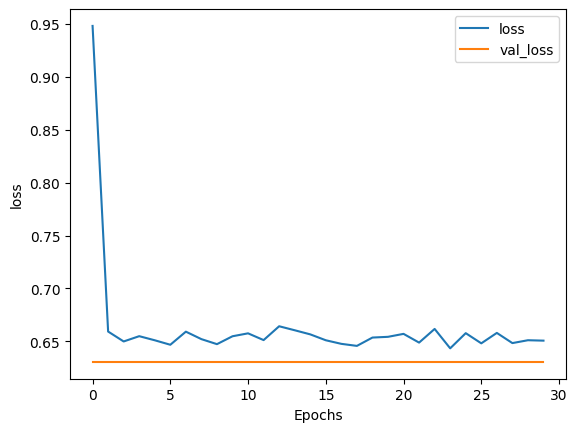

10/10 [==============================] - 11s 81ms/step


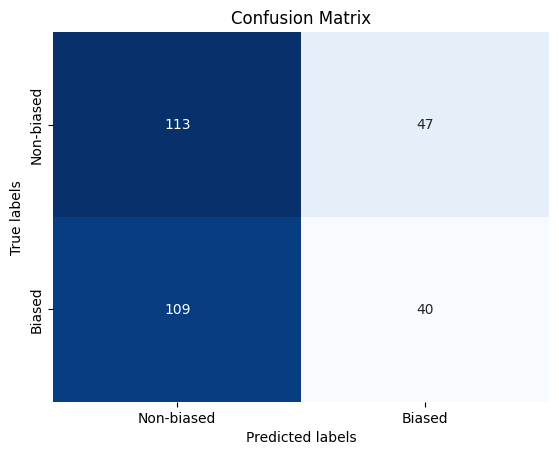

### Start fold 4


Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFRobertaForSequenceClassification: ['roberta.embeddings.position_ids']
- This IS expected if you are initializing TFRobertaForSequenceClassification from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFRobertaForSequenceClassification from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
Some weights or buffers of the TF 2.0 model TFRobertaForSequenceClassification were not initialized from the PyTorch model and are newly initialized: ['classifier.dense.weight', 'classifier.dense.bias', 'classifier.out_proj.weight', 'classifier.out_proj.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predicti

Epoch 1/30
40/40 [==============================] - 104s 721ms/step - loss: 0.7362 - val_loss: 0.6284
Epoch 2/30
40/40 [==============================] - 13s 333ms/step - loss: 0.6673 - val_loss: 0.6284
Epoch 3/30
40/40 [==============================] - 13s 321ms/step - loss: 0.6839 - val_loss: 0.6284
Epoch 4/30
40/40 [==============================] - 12s 309ms/step - loss: 0.6936 - val_loss: 0.6284
Epoch 5/30
40/40 [==============================] - 12s 311ms/step - loss: 0.6684 - val_loss: 0.6284
Epoch 6/30
40/40 [==============================] - 12s 302ms/step - loss: 0.6768 - val_loss: 0.6284
Epoch 7/30
40/40 [==============================] - 13s 316ms/step - loss: 0.6666 - val_loss: 0.6284
Epoch 8/30
40/40 [==============================] - 13s 315ms/step - loss: 0.6642 - val_loss: 0.6284
Epoch 9/30
40/40 [==============================] - 12s 297ms/step - loss: 0.6604 - val_loss: 0.6284
Epoch 10/30
40/40 [==============================] - 12s 294ms/step - loss: 0.6594 - val_l

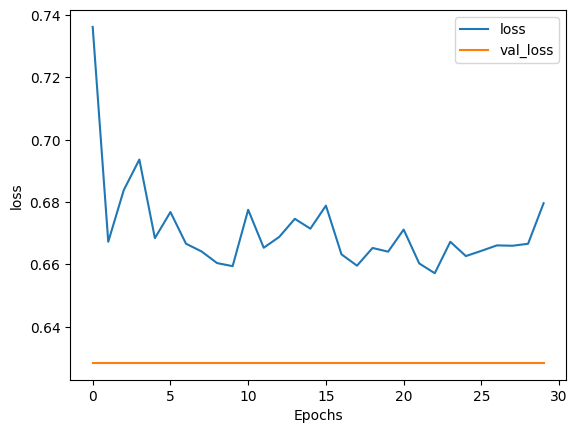

10/10 [==============================] - 11s 83ms/step


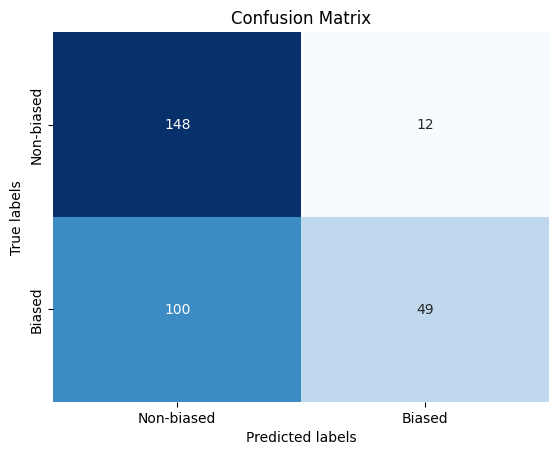

### Start fold 5


Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFRobertaForSequenceClassification: ['roberta.embeddings.position_ids']
- This IS expected if you are initializing TFRobertaForSequenceClassification from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFRobertaForSequenceClassification from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
Some weights or buffers of the TF 2.0 model TFRobertaForSequenceClassification were not initialized from the PyTorch model and are newly initialized: ['classifier.dense.weight', 'classifier.dense.bias', 'classifier.out_proj.weight', 'classifier.out_proj.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predicti

Epoch 1/30
40/40 [==============================] - 103s 720ms/step - loss: 2.2799 - val_loss: 0.6957
Epoch 2/30
40/40 [==============================] - 13s 329ms/step - loss: 0.7282 - val_loss: 0.6957
Epoch 3/30
40/40 [==============================] - 13s 319ms/step - loss: 0.7361 - val_loss: 0.6957
Epoch 4/30
40/40 [==============================] - 12s 313ms/step - loss: 0.7718 - val_loss: 0.6957
Epoch 5/30
40/40 [==============================] - 13s 312ms/step - loss: 0.7359 - val_loss: 0.6957
Epoch 6/30
40/40 [==============================] - 12s 304ms/step - loss: 0.7066 - val_loss: 0.6957
Epoch 7/30
40/40 [==============================] - 12s 303ms/step - loss: 0.7577 - val_loss: 0.6957
Epoch 8/30
40/40 [==============================] - 12s 301ms/step - loss: 0.7545 - val_loss: 0.6957
Epoch 9/30
40/40 [==============================] - 12s 307ms/step - loss: 0.7660 - val_loss: 0.6957
Epoch 10/30
40/40 [==============================] - 12s 305ms/step - loss: 0.7345 - val_l

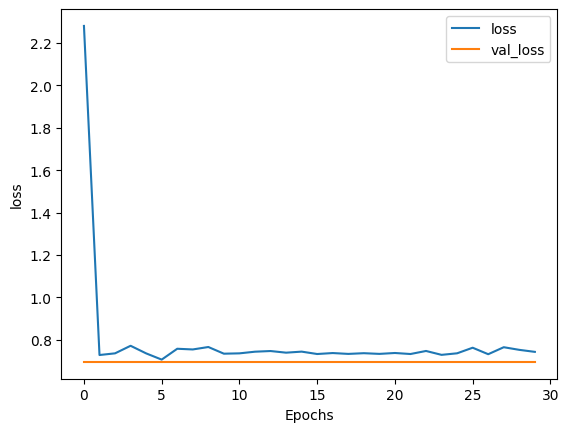

10/10 [==============================] - 12s 116ms/step


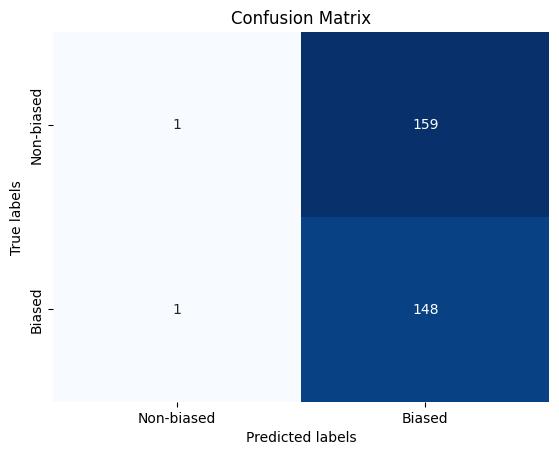

Results for Roberta on SG1
5-Fold CV Loss: 0.6728020310401917
5-Fold CV Accuracy: 0.5181292410481261
5-Fold CV Precision: 0.5005870787227618
5-Fold CV Recall: 0.49950782997762866
5-Fold CV F1 Score: 0.42939150650123
5-Fold CV Micro F1 Score: 0.5181292410481261
5-Fold CV Weighted Macro F1 Score: 0.4341472134264954


In [ ]:
tokenizer = RobertaTokenizer.from_pretrained('FacebookAI/roberta-base')
val_loss, val_acc, val_prec, val_rec, val_f1, val_f1_micro, val_f1_wmacro = run_model_5fold(df1, named_file='df1',freeze_encoder=False, pretrained=False, plot=True)
loss_cv = np.mean(val_loss)
acc_cv = np.mean(val_acc)
prec_cv = np.mean(val_prec)
rec_cv = np.mean(val_rec)
f1_cv = np.mean(val_f1)
f1_micro_cv = np.mean(val_f1_micro)
f1_wmacro_cv = np.mean(val_f1_wmacro)

print('Results for Roberta on SG1')
print('5-Fold CV Loss: {}'.format(loss_cv))
print('5-Fold CV Accuracy: {}'.format(acc_cv))
print('5-Fold CV Precision: {}'.format(prec_cv))
print('5-Fold CV Recall: {}'.format(rec_cv))
print('5-Fold CV F1 Score: {}'.format(f1_cv))
print('5-Fold CV Micro F1 Score: {}'.format(f1_micro_cv))
print('5-Fold CV Weighted Macro F1 Score: {}'.format(f1_wmacro_cv))

Run the model similarily on SG2

model.safetensors:   0%|          | 0.00/499M [00:00<?, ?B/s]

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at FacebookAI/roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1, Train Loss: 0.24057267355906256
Epoch 1, Val Loss: 0.2034851871430874
Epoch 2, Train Loss: 0.22117956281813272
Epoch 2, Val Loss: 0.4389612996264508
Epoch 3, Train Loss: 0.1770233749214686
Epoch 3, Val Loss: 0.24074902228618922


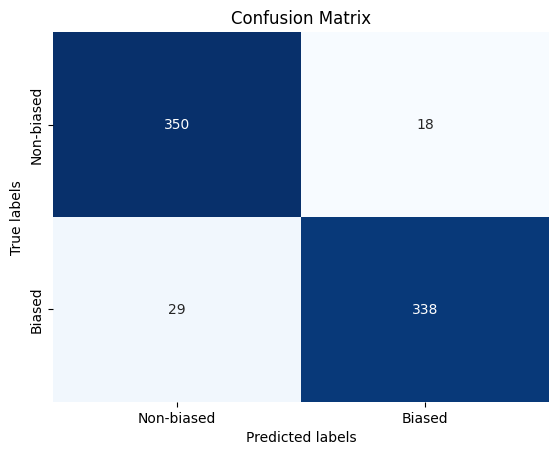

Results for Roberta on SG2
Test Loss: 0.18801647489485535
Test Accuracy: 0.9360544217687075
Test Precision: 0.949438202247191
Test Recall: 0.9209809264305178
Test F1 Score: 0.9349930843706777
Test Micro F1 Score: 0.9360544217687075
Test Weighted Macro F1 Score: 0.9360387929716816


In [ ]:
tokenizer = RobertaTokenizer.from_pretrained('FacebookAI/roberta-base')
test_loss, test_acc, test_prec, test_rec, test_f1, test_f1_micro, test_f1_wmacro = run_model(df2, named_file='df3',freeze_encoder=False, pretrained=False, plot=False, init_type='xavier')

print('Results for Roberta on SG2')
print('Test Loss: {}'.format(test_loss))
print('Test Accuracy: {}'.format(test_acc))
print('Test Precision: {}'.format(test_prec))
print('Test Recall: {}'.format(test_rec))
print('Test F1 Score: {}'.format(test_f1))
print('Test Micro F1 Score: {}'.format(test_f1_micro))
print('Test Weighted Macro F1 Score: {}'.format(test_f1_wmacro))


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/481 [00:00<?, ?B/s]

### Start fold 1


model.safetensors:   0%|          | 0.00/499M [00:00<?, ?B/s]

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFRobertaForSequenceClassification: ['roberta.embeddings.position_ids']
- This IS expected if you are initializing TFRobertaForSequenceClassification from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFRobertaForSequenceClassification from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
Some weights or buffers of the TF 2.0 model TFRobertaForSequenceClassification were not initialized from the PyTorch model and are newly initialized: ['classifier.dense.weight', 'classifier.dense.bias', 'classifier.out_proj.weight', 'classifier.out_proj.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predicti

Epoch 1/30


Cause: for/else statement not yet supported
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Cause: for/else statement not yet supported
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
94/94 [==============================] - 147s 505ms/step - loss: 0.9063 - val_loss: 0.5411
Epoch 2/30
94/94 [==============================] - 30s 316ms/step - loss: 0.5906 - val_loss: 0.5411
Epoch 3/30
94/94 [==============================] - 29s 312ms/step - loss: 0.5882 - val_loss: 0.5411
Epoch 4/30
94/94 [==============================] - 28s 297ms/step - loss: 0.5936 - val_loss: 0.5411
Epoch 5/30
94/94 [==============================] - 28s 296ms/step - loss: 0.5892 - val_loss: 0.5411
Epoch 6/30
94/94 [==============================] - 28s 295ms/step - loss: 0.5898 - val_loss: 0.5411
Epoch 7/30
94/94 [==============================] - 27s 292ms/step - loss: 0.5902 - val_loss: 0.5411
Epoch 8/30
94/94 [==============================] - 28s 295ms/step - loss: 0.5941 - val_loss: 0.5411
Epoch 9/30
94/94 [==============================] - 28s 295ms/st

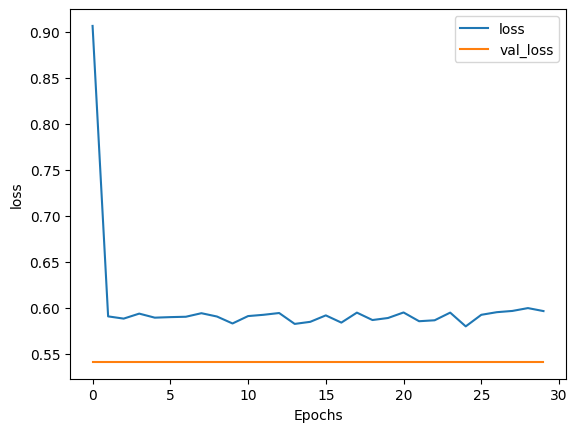

23/23 [==============================] - 11s 86ms/step


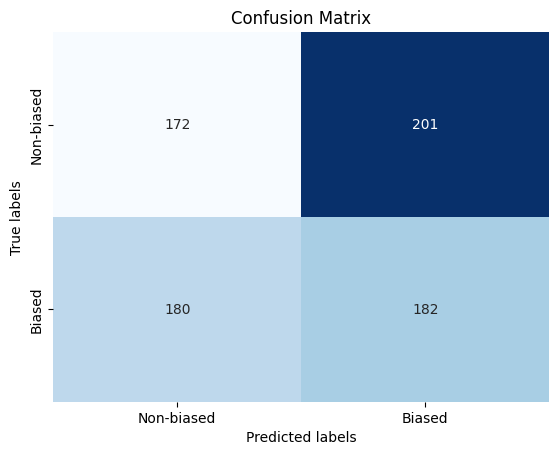

### Start fold 2


Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFRobertaForSequenceClassification: ['roberta.embeddings.position_ids']
- This IS expected if you are initializing TFRobertaForSequenceClassification from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFRobertaForSequenceClassification from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
Some weights or buffers of the TF 2.0 model TFRobertaForSequenceClassification were not initialized from the PyTorch model and are newly initialized: ['classifier.dense.weight', 'classifier.dense.bias', 'classifier.out_proj.weight', 'classifier.out_proj.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predicti

Epoch 1/30
94/94 [==============================] - 107s 460ms/step - loss: 0.7190 - val_loss: 0.5414
Epoch 2/30
94/94 [==============================] - 28s 299ms/step - loss: 0.5718 - val_loss: 0.5414
Epoch 3/30
94/94 [==============================] - 28s 298ms/step - loss: 0.5870 - val_loss: 0.5414
Epoch 4/30
94/94 [==============================] - 28s 293ms/step - loss: 0.5846 - val_loss: 0.5414
Epoch 5/30
94/94 [==============================] - 28s 298ms/step - loss: 0.5788 - val_loss: 0.5414
Epoch 6/30
94/94 [==============================] - 27s 290ms/step - loss: 0.5795 - val_loss: 0.5414
Epoch 7/30
94/94 [==============================] - 27s 288ms/step - loss: 0.5773 - val_loss: 0.5414
Epoch 8/30
94/94 [==============================] - 27s 290ms/step - loss: 0.5706 - val_loss: 0.5414
Epoch 9/30
94/94 [==============================] - 27s 287ms/step - loss: 0.5895 - val_loss: 0.5414
Epoch 10/30
94/94 [==============================] - 27s 288ms/step - loss: 0.5821 - val_l

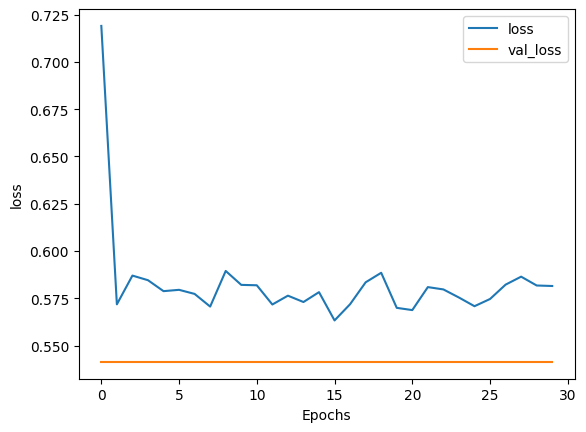

23/23 [==============================] - 11s 81ms/step


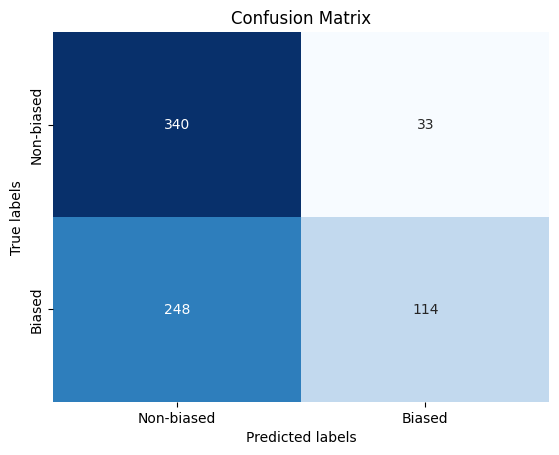

### Start fold 3


Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFRobertaForSequenceClassification: ['roberta.embeddings.position_ids']
- This IS expected if you are initializing TFRobertaForSequenceClassification from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFRobertaForSequenceClassification from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
Some weights or buffers of the TF 2.0 model TFRobertaForSequenceClassification were not initialized from the PyTorch model and are newly initialized: ['classifier.dense.weight', 'classifier.dense.bias', 'classifier.out_proj.weight', 'classifier.out_proj.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predicti

Epoch 1/30
94/94 [==============================] - 108s 454ms/step - loss: 0.7381 - val_loss: 0.4885
Epoch 2/30
94/94 [==============================] - 28s 302ms/step - loss: 0.5388 - val_loss: 0.4885
Epoch 3/30
94/94 [==============================] - 28s 295ms/step - loss: 0.5435 - val_loss: 0.4885
Epoch 4/30
94/94 [==============================] - 27s 290ms/step - loss: 0.5544 - val_loss: 0.4885
Epoch 5/30
94/94 [==============================] - 27s 291ms/step - loss: 0.5571 - val_loss: 0.4885
Epoch 6/30
94/94 [==============================] - 27s 290ms/step - loss: 0.5413 - val_loss: 0.4885
Epoch 7/30
94/94 [==============================] - 28s 295ms/step - loss: 0.5442 - val_loss: 0.4885
Epoch 8/30
94/94 [==============================] - 28s 297ms/step - loss: 0.5369 - val_loss: 0.4885
Epoch 9/30
94/94 [==============================] - 27s 288ms/step - loss: 0.5522 - val_loss: 0.4885
Epoch 10/30
94/94 [==============================] - 27s 288ms/step - loss: 0.5331 - val_l

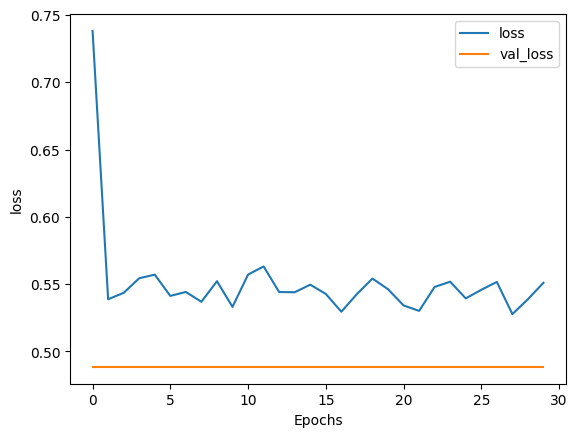

23/23 [==============================] - 10s 82ms/step


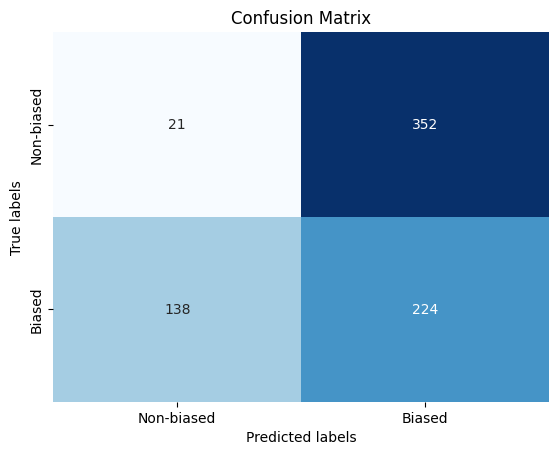

### Start fold 4


Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFRobertaForSequenceClassification: ['roberta.embeddings.position_ids']
- This IS expected if you are initializing TFRobertaForSequenceClassification from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFRobertaForSequenceClassification from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
Some weights or buffers of the TF 2.0 model TFRobertaForSequenceClassification were not initialized from the PyTorch model and are newly initialized: ['classifier.dense.weight', 'classifier.dense.bias', 'classifier.out_proj.weight', 'classifier.out_proj.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predicti

Epoch 1/30
94/94 [==============================] - 109s 462ms/step - loss: 0.6907 - val_loss: 0.5736
Epoch 2/30
94/94 [==============================] - 29s 309ms/step - loss: 0.5452 - val_loss: 0.5736
Epoch 3/30
94/94 [==============================] - 28s 298ms/step - loss: 0.5471 - val_loss: 0.5736
Epoch 4/30
94/94 [==============================] - 27s 292ms/step - loss: 0.5468 - val_loss: 0.5736
Epoch 5/30
94/94 [==============================] - 27s 293ms/step - loss: 0.5396 - val_loss: 0.5736
Epoch 6/30
94/94 [==============================] - 27s 291ms/step - loss: 0.5463 - val_loss: 0.5736
Epoch 7/30
94/94 [==============================] - 27s 290ms/step - loss: 0.5496 - val_loss: 0.5736
Epoch 8/30
94/94 [==============================] - 27s 291ms/step - loss: 0.5483 - val_loss: 0.5736
Epoch 9/30
94/94 [==============================] - 27s 292ms/step - loss: 0.5513 - val_loss: 0.5736
Epoch 10/30
94/94 [==============================] - 27s 292ms/step - loss: 0.5401 - val_l

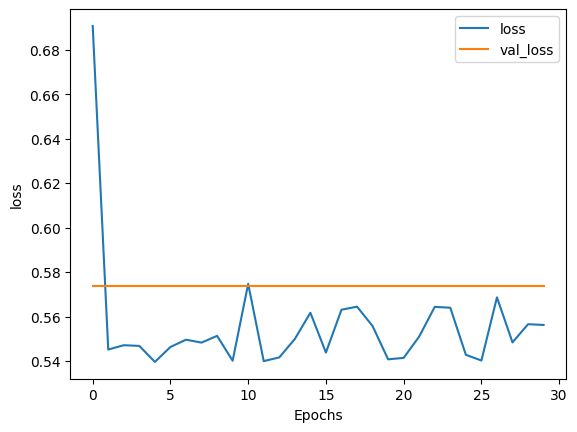

23/23 [==============================] - 12s 87ms/step


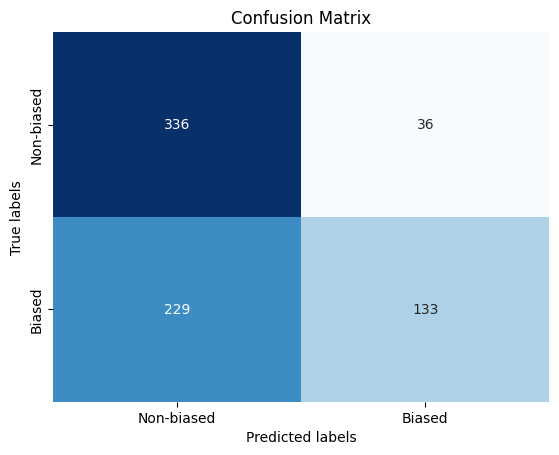

### Start fold 5


Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFRobertaForSequenceClassification: ['roberta.embeddings.position_ids']
- This IS expected if you are initializing TFRobertaForSequenceClassification from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFRobertaForSequenceClassification from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
Some weights or buffers of the TF 2.0 model TFRobertaForSequenceClassification were not initialized from the PyTorch model and are newly initialized: ['classifier.dense.weight', 'classifier.dense.bias', 'classifier.out_proj.weight', 'classifier.out_proj.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predicti

Epoch 1/30
94/94 [==============================] - 106s 459ms/step - loss: 1.2977 - val_loss: 0.5333
Epoch 2/30
94/94 [==============================] - 26s 280ms/step - loss: 0.5999 - val_loss: 0.5333
Epoch 3/30
94/94 [==============================] - 26s 273ms/step - loss: 0.5961 - val_loss: 0.5333
Epoch 4/30
94/94 [==============================] - 25s 271ms/step - loss: 0.6193 - val_loss: 0.5333
Epoch 5/30
94/94 [==============================] - 25s 271ms/step - loss: 0.5980 - val_loss: 0.5333
Epoch 6/30
94/94 [==============================] - 26s 272ms/step - loss: 0.6111 - val_loss: 0.5333
Epoch 7/30
94/94 [==============================] - 25s 268ms/step - loss: 0.6116 - val_loss: 0.5333
Epoch 8/30
94/94 [==============================] - 25s 266ms/step - loss: 0.6355 - val_loss: 0.5333
Epoch 9/30
94/94 [==============================] - 25s 266ms/step - loss: 0.6107 - val_loss: 0.5333
Epoch 10/30
94/94 [==============================] - 25s 267ms/step - loss: 0.5892 - val_l

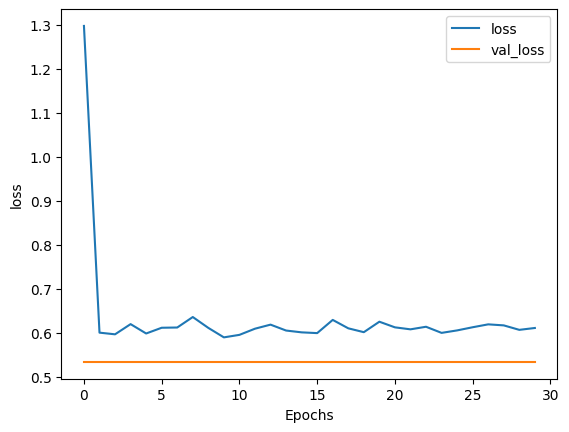

23/23 [==============================] - 12s 97ms/step


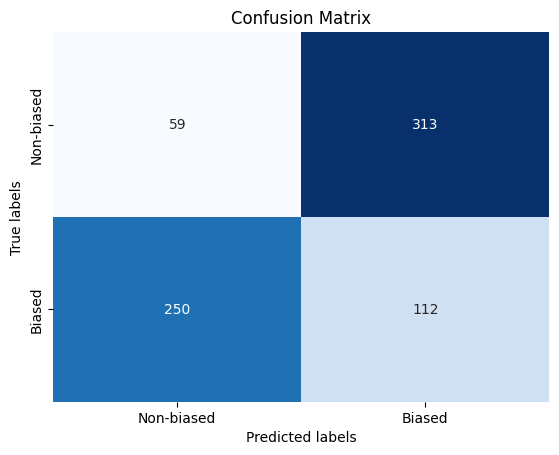

Results for Roberta on SG12
5-Fold CV Loss: 0.5355850219726562
5-Fold CV Accuracy: 0.46091753322582435
5-Fold CV Precision: 0.5380213151420492
5-Fold CV Recall: 0.42265193370165743
5-Fold CV F1 Score: 0.4399412908745385
5-Fold CV Micro F1 Score: 0.46091753322582435
5-Fold CV Weighted Macro F1 Score: 0.43503274607070874


In [ ]:
tokenizer = RobertaTokenizer.from_pretrained('FacebookAI/roberta-base')
val_loss, val_acc, val_prec, val_rec, val_f1, val_f1_micro, val_f1_wmacro = run_model_5fold(df2, named_file='df2',freeze_encoder=False, pretrained=False, plot=True)
loss_cv = np.mean(val_loss)
acc_cv = np.mean(val_acc)
prec_cv = np.mean(val_prec)
rec_cv = np.mean(val_rec)
f1_cv = np.mean(val_f1)
f1_micro_cv = np.mean(val_f1_micro)
f1_wmacro_cv = np.mean(val_f1_wmacro)

print('Results for Roberta on SG12')
print('5-Fold CV Loss: {}'.format(loss_cv))
print('5-Fold CV Accuracy: {}'.format(acc_cv))
print('5-Fold CV Precision: {}'.format(prec_cv))
print('5-Fold CV Recall: {}'.format(rec_cv))
print('5-Fold CV F1 Score: {}'.format(f1_cv))
print('5-Fold CV Micro F1 Score: {}'.format(f1_micro_cv))
print('5-Fold CV Weighted Macro F1 Score: {}'.format(f1_wmacro_cv))

Applying Baseline functions to SG1 dataset

Majority Class Classifier Report:
              precision    recall  f1-score   support

           0  0.53870968 1.00000000 0.70020964       167
           1  0.00000000 0.00000000 0.00000000       143

    accuracy                      0.53870968       310
   macro avg  0.26935484 0.50000000 0.35010482       310
weighted avg  0.29020812 0.53870968 0.37720971       310



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


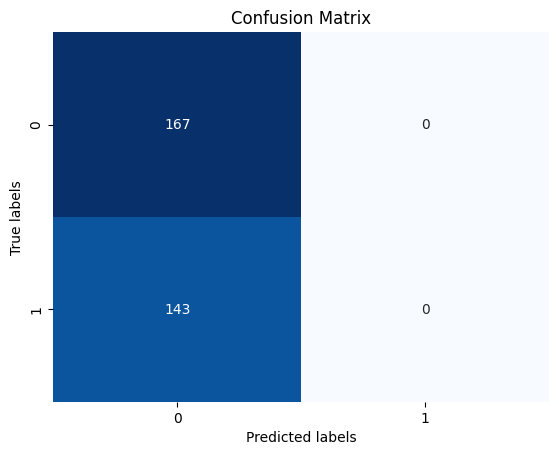

Random Guesser Report:
              precision    recall  f1-score   support

           0  0.57500000 0.55089820 0.56269113       167
           1  0.50000000 0.52447552 0.51194539       143

    accuracy                      0.53870968       310
   macro avg  0.53750000 0.53768686 0.53731826       310
weighted avg  0.54040323 0.53870968 0.53928261       310



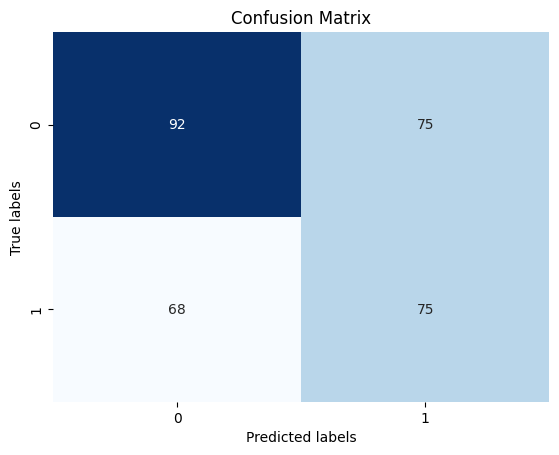

CountVectorizer with Logistic Regression Report:
              precision    recall  f1-score   support

           0  0.66878981 0.62874251 0.64814815       167
           1  0.59477124 0.63636364 0.61486486       143

    accuracy                      0.63225806       310
   macro avg  0.63178053 0.63255308 0.63150651       310
weighted avg  0.63464576 0.63225806 0.63279489       310



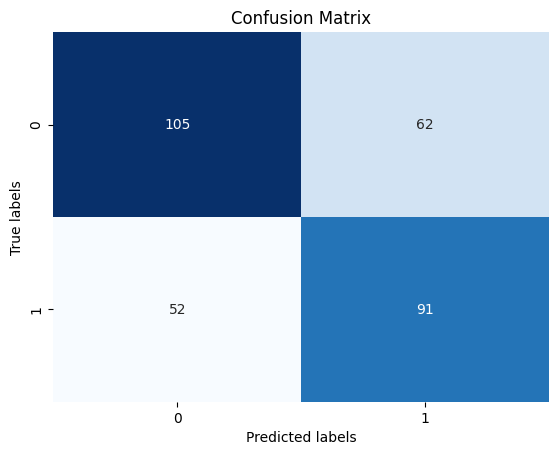

Neural Network Classifier Report:
              precision    recall  f1-score   support

           0  0.61643836 0.80838323 0.69948187       167
           1  0.64835165 0.41258741 0.50427350       143

    accuracy                      0.62580645       310
   macro avg  0.63239500 0.61048532 0.60187768       310
weighted avg  0.63115965 0.62580645 0.60943414       310



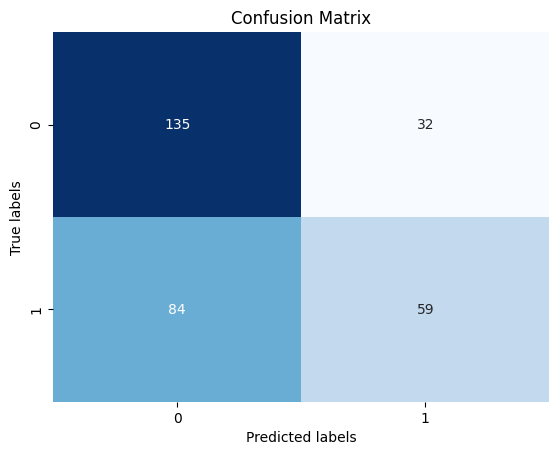

In [9]:
# Assuming df is the DataFrame and "text" and "label_bias" are the columns
X = df1['text']
y = df1['label_bias']

# Split the data into train, validation, and test sets
X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=0.2, random_state=42)

# Vectorize the text data using CountVectorizer
vectorizer = CountVectorizer()
X_train_tfidf = vectorizer.fit_transform(X_train)
X_val_tfidf = vectorizer.transform(X_val)
X_test_tfidf = vectorizer.transform(X_test)

# Majority Class Classifier
majority_class_classifier = DummyClassifier(strategy='most_frequent')
majority_class_classifier.fit(X_train_tfidf, y_train)
y_pred = majority_class_classifier.predict(X_test_tfidf)
print("Majority Class Classifier Report:")
print(classification_report(y_test, y_pred, digits=8))
plot_confusion_matrix(y_test, y_pred, classes=np.unique(y), filename='majority_class_classifier_cm_SG1.png')

# Random Guesser
random_guesser = DummyClassifier(strategy='uniform')
random_guesser.fit(X_train_tfidf, y_train)
y_pred = random_guesser.predict(X_test_tfidf)
print("Random Guesser Report:")
print(classification_report(y_test, y_pred, digits=8))
plot_confusion_matrix(y_test, y_pred, classes=np.unique(y), filename='random_guesser_cm_SG1.png')

# CountVectorizer with Logistic Regression
logistic_regression = LogisticRegression()
logistic_regression.fit(X_train_tfidf, y_train)
y_pred = logistic_regression.predict(X_test_tfidf)
print("CountVectorizer with Logistic Regression Report:")
print(classification_report(y_test, y_pred, digits=8))
plot_confusion_matrix(y_test, y_pred, classes=np.unique(y), filename='logistic_regression_cm_SG1.png')

# Neural network classifier with 10 layers, each with 100 neurons
neural_net = MLPClassifier(hidden_layer_sizes=(100,)*10, random_state=42)
neural_net.fit(X_train_tfidf, y_train)
y_pred = neural_net.predict(X_test_tfidf)
print("Neural Network Classifier Report:")
print(classification_report(y_test, y_pred, digits=8))
plot_confusion_matrix(y_test, y_pred, classes=np.unique(y), filename='neural_net_cm_SG1.png')

Now For the Second Dataset

Majority Class Classifier Report:
              precision    recall  f1-score   support

           0  0.51156463 1.00000000 0.67686769       376
           1  0.00000000 0.00000000 0.00000000       359

    accuracy                      0.51156463       735
   macro avg  0.25578231 0.50000000 0.33843384       735
weighted avg  0.26169837 0.51156463 0.34626156       735



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


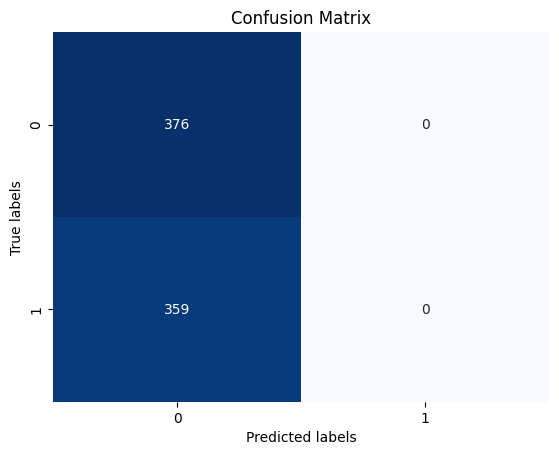

Random Guesser Report:
              precision    recall  f1-score   support

           0  0.51780822 0.50265957 0.51012146       376
           1  0.49459459 0.50974930 0.50205761       359

    accuracy                      0.50612245       735
   macro avg  0.50620141 0.50620444 0.50608954       735
weighted avg  0.50646986 0.50612245 0.50618279       735



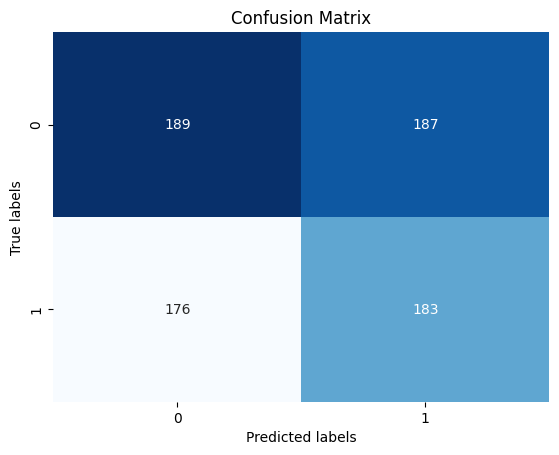

CountVectorizer with Logistic Regression Report:
              precision    recall  f1-score   support

           0  0.72423398 0.69148936 0.70748299       376
           1  0.69148936 0.72423398 0.70748299       359

    accuracy                      0.70748299       735
   macro avg  0.70786167 0.70786167 0.70748299       735
weighted avg  0.70824035 0.70748299 0.70748299       735



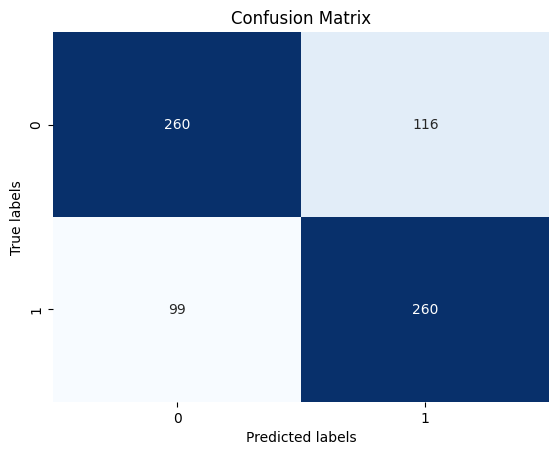

Neural Network Classifier Report:
              precision    recall  f1-score   support

           0  0.70175439 0.63829787 0.66852368       376
           1  0.65394402 0.71587744 0.68351064       359

    accuracy                      0.67619048       735
   macro avg  0.67784920 0.67708765 0.67601716       735
weighted avg  0.67840211 0.67619048 0.67584384       735



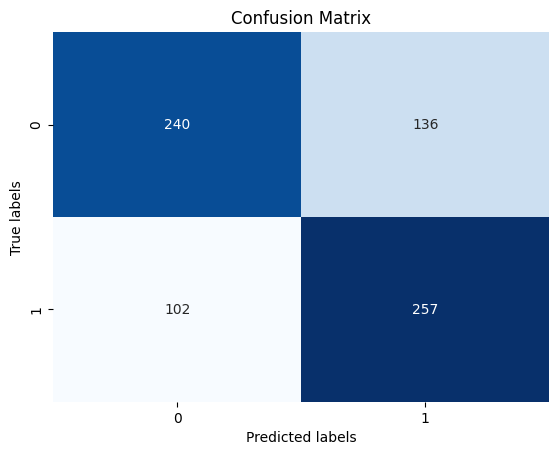

In [10]:
# Assuming df is the DataFrame and "text" and "label_bias" are columns
X = df2['text']
y = df2['label_bias']

# Split the data into train, validation, and test sets
X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=0.2, random_state=42)

# Vectorize the text data using CountVectorizer
vectorizer = CountVectorizer()
X_train_tfidf = vectorizer.fit_transform(X_train)
X_val_tfidf = vectorizer.transform(X_val)
X_test_tfidf = vectorizer.transform(X_test)

# Majority Class Classifier
majority_class_classifier = DummyClassifier(strategy='most_frequent')
majority_class_classifier.fit(X_train_tfidf, y_train)
y_pred = majority_class_classifier.predict(X_test_tfidf)
print("Majority Class Classifier Report:")
print(classification_report(y_test, y_pred, digits=8))
plot_confusion_matrix(y_test, y_pred, classes=np.unique(y), filename='majority_class_classifier_cm_SG2.png')

# Random Guesser
random_guesser = DummyClassifier(strategy='uniform')
random_guesser.fit(X_train_tfidf, y_train)
y_pred = random_guesser.predict(X_test_tfidf)
print("Random Guesser Report:")
print(classification_report(y_test, y_pred, digits=8))
plot_confusion_matrix(y_test, y_pred, classes=np.unique(y), filename='random_guesser_cm_SG2.png')

# CountVectorizer with Logistic Regression
logistic_regression = LogisticRegression(tol=1e-5, max_iter=2000)
logistic_regression.fit(X_train_tfidf, y_train)
y_pred = logistic_regression.predict(X_test_tfidf)
print("CountVectorizer with Logistic Regression Report:")
print(classification_report(y_test, y_pred, digits=8))
plot_confusion_matrix(y_test, y_pred, classes=np.unique(y), filename='logistic_regression_cm_SG2.png')

# Neural network classifier with 10 layers, each with 100 neurons
neural_net = MLPClassifier(hidden_layer_sizes=(100,)*10, random_state=42)
neural_net.fit(X_train_tfidf, y_train)
y_pred = neural_net.predict(X_test_tfidf)
print("Neural Network Classifier Report:")
print(classification_report(y_test, y_pred, digits=8))
plot_confusion_matrix(y_test, y_pred, classes=np.unique(y), filename='neural_net_cm_SG2.png')


The last step is the interpretation of the model's predictions using the AnchorText explainer from the Alibi library. The explainer generates an explanation for a given text by finding a set of words that are highly predictive of the model's prediction. The explanation is returned as a set of words (the anchor) and a precision score, which is the model's prediction accuracy when the anchor is present in the text. The precision score is a measure of the anchor's reliability, and a higher precision score indicates a more reliable anchor. The threshold parameter is used to control the precision score, and the explainer will return an anchor with a precision score greater than or equal to the threshold.
The sampling_strategy parameter is used to control the sampling strategy for generating the anchor, and the nlp parameter is used to specify the spaCy model to be used for tokenization and similarity calculations.
The following code demonstrates how to use the AnchorText explainer to generate an explanation for a given text.
The similarity sampling strategy is used to generate the anchor, and the en_core_web_md spaCy model is used for tokenization and similarity calculations.
The reasons for selecting the similarity sampling strategy:
1. Similarity Sampling uses corpus embeddings to generate samples that are contextually similar to the original text. This will likely maintain the semantic context of the original text, which leads to more meaningful explanations.
2. This can make the explanations easier to understand for users, as the anchors are more interpretable.

In [ ]:
os.system('python -m spacy download en_core_web_md')
nlp = spacy.load('en_core_web_md')

In [ ]:
df = pd.read_excel('/content/drive/MyDrive/Data_Sets/final_labels_SG2.xlsx')

In [ ]:
df = pd.read_excel('/content/drive/MyDrive/final_labels_SG2.xlsx')

# Evaluation by visual plots and model agnostics
The first methods used is the visualization of classification clusters and analyzing the distribution of sentences the second method would be to analyze using the AnchorText to interpret the the resulting classes using an explainer

In [ ]:
model_name = "prajjwal1/bert-tiny"
ex_tokenizer = AutoTokenizer.from_pretrained(model_name)
extractor_model = AutoModel.from_pretrained(model_name)
extractor = pipeline("feature-extraction", batch_size=512, model=extractor_model, tokenizer=ex_tokenizer)

def plot_tsne(vectors, labels, file_name, perplexity=30.0, n_iter=1000):
    """
    Compute and plot a t-SNE reduction of the given vectors and save the plot to a file.

    Arguments:
        vectors (list): A list of embedding vectors.
        labels (list): A list of class labels; must have the same length as `vectors`.
        file_name (str): The name of the file to save the plot.
        perplexity (float, optional): A hyperparameter of the t-SNE algorithm; recommended values
            are between 5 and 50, and can result in significantly different results. Defaults to 30.0.
        n_iter (int, optional): A hyperparameter of the t-SNE algorithm, controlling the maximum
            number of iterations of the optimization algorithm. Defaults to 1000.

    Returns:
        None. The function saves the plot to a file.
    """
    tsne = TSNE(verbose=True, perplexity=perplexity, n_iter=n_iter)
    vectors = np.stack(vectors.values)
    vectors_2d = tsne.fit_transform(np.array(vectors))

    # Create a scatter plot
    plt.figure(figsize=(10, 10))
    scatter = plt.scatter(vectors_2d[:, 0], vectors_2d[:, 1], c=labels, cmap='viridis')

    # Add a color bar
    plt.colorbar(scatter)

    # Save the plot
    plt.savefig(file_name)


def extract_embeddings(sentences, token):
    """Encodes sentences and for each sentence, returns the vector corresponding to the given token.

    Arguments:
        sentences (list[str]): The sentences to feed into the model.
        token (str): The token to extract the embedding for.

    Returns:
        A list of vectors, one vector for each input sentence, corresponding to the contextual embedding
        of `token` within `sentence`. (This can be either a PyTorch tensor or a NumPy array.)
    """
    vectors = []
    for sentence in sentences:
        input_ids = ex_tokenizer(sentence)["input_ids"]
        token_id  = ex_tokenizer.vocab[token]
        token_idx = input_ids.index(token_id)
        output = extractor(sentence, return_tensors=True)
        vectors.append(output[0][token_idx][:].numpy())
    return vectors

In [ ]:
# Create True Labels
# Assuming df2 is the DataFrame and "text" and "label_bias" are the columns
model = RobertaForSequenceClassification.from_pretrained('FacebookAI/roberta-base')
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.load_state_dict(torch.load('/content/drive/MyDrive/df3_Roberta_fine_tuned_pure.pt', map_location=device))

# Load the tokenizer
tokenizer = RobertaTokenizer.from_pretrained('FacebookAI/roberta-base')

model = model.to(device)

Sentences = df2['text']
TrueLabels = df2['label_bias']

# Create the Label lists from the Baselines and RoBERTa
texts_tfidf = vectorizer.transform(Sentences)
Labels_Majority = majority_class_classifier.predict(texts_tfidf)
Labels_Random = random_guesser.predict(texts_tfidf)
Labels_Logistic = logistic_regression.predict(texts_tfidf)

# Using list Comprehension
Labels_RoBERTa = [
    torch.max(
        model(
            (inputs := tokenizer.encode_plus(
                text,
                add_special_tokens=True,  # add [CLS], [SEP]
                truncation=True,  # cut off at max length of the text that can go to BERT
                padding=True,
                return_attention_mask=True,  # add attention mask to not focus on pad tokens
                return_tensors='pt'  # return PyTorch tensors
            ))['input_ids'].to(device),
            attention_mask=inputs['attention_mask'].to(device)
        ).logits,
        dim=1
    )[1].item()
    for text in X
]

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at FacebookAI/roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
print(len(Sentences),len(TrueLabels),len(Labels_Majority),len(Labels_Random),len(Labels_Logistic),len(Labels_RoBERTa))

3673 3673 3673 3673 3673 3673


In [ ]:
# create an inspection dataset containining the resulting labels from
df = pd.DataFrame({
    "Sentences": Sentences,
    "TrueLabels": TrueLabels,
    "Labels_Majority": Labels_Majority,
    "Labels_Random": Labels_Random,
    "Labels_Logistic": Labels_Logistic,
    "Labels_RoBERTa": Labels_RoBERTa
})

# Apply the function to the Sentences column and write the resulting embedding to a new column called Extracted_EMBD
df.insert(1, "Extracted_EMBD", extract_embeddings(df["Sentences"], '[CLS]'))

# Print the DataFrame
print(df.head(5))
df.to_csv('labels.csv', index=False)

# Create plots for each of the label column using Extracted_EMBD as vectors argument
label_columns = ["TrueLabels", "Labels_Majority", "Labels_Random", "Labels_Logistic", "Labels_RoBERTa"]
for label_column in label_columns:
    plot_tsne(df["Extracted_EMBD"], df[label_column], f"{label_column}_tsne_plot.png")

Output hidden; open in https://colab.research.google.com to view.

In [ ]:
# Define the predict function
# def predict_fn(texts):
#     predictions = []
#     for text in texts:
#         # Tokenize the text
#         inputs = tokenizer.encode_plus(
#             text,
#             add_special_tokens=True,  # add [CLS], [SEP]
#             truncation=True,  # cut off at max length of the text that can go to BERT
#             padding=True,  # add [PAD] tokens
#             return_attention_mask=True,  # add attention mask to not focus on pad tokens
#             return_tensors='pt'  # return PyTorch tensors
#         )
#         # Get the prediction
#         with torch.no_grad():
#             outputs = model(inputs['input_ids'], attention_mask=inputs['attention_mask'])
#         _, preds = torch.max(outputs.logits, dim=1)
#         predictions.append(preds.item())
#     return np.array(predictions, dtype=np.int64)
# Initialize the tokenizer
tokenizer = RobertaTokenizer.from_pretrained('FacebookAI/roberta-base')
model = RobertaForSequenceClassification.from_pretrained('FacebookAI/roberta-base')
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)
model.load_state_dict(torch.load('/content/drive/MyDrive/df3_Roberta_fine_tuned_pure.pt', map_location=device))

def predict_fn(texts):
    predictions = [
        torch.max(
            model(
                (inputs := tokenizer.encode_plus(
                    text,
                    add_special_tokens=True,  # add [CLS], [SEP]
                    truncation=True,  # cut off at max length of the text that can go to BERT
                    padding=True,  # add [PAD] tokens
                    return_attention_mask=True,  # add attention mask to not focus on pad tokens
                    return_tensors='pt'  # return PyTorch tensors
                ))['input_ids'].to(device),
                attention_mask=inputs['attention_mask'].to(device)
            ).logits,
            dim=1
        )[1].item()
        for text in texts
    ]
    return np.array(predictions, dtype=np.int64)

explainer = AnchorText(predictor=predict_fn, sampling_strategy='similarity', nlp=nlp)
explanation = explainer.explain('A Biden victory would ensure government-imposed thought-police courses that are anti-history, anti-free thought, anti-White, and anti-male.', threshold=0.95)

# Print the explanation
print('Anchor: %s' % (' AND '.join(explanation.anchor)))
print('Precision: %.2f' % explanation.precision)


Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at FacebookAI/roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Anchor: White AND courses AND male AND and AND A AND - AND , AND - AND anti AND are AND Biden AND , AND - AND - AND - AND - AND . AND would AND that AND ,
Precision: 0.91


In [ ]:
# Initialize the explainer
explainer = AnchorText(predictor=predict_fn, sampling_strategy='similarity', nlp=nlp)

# Generate explanation
explanation = explainer.explain('Civil rights activists across the United States for years have called for scaling back traditional policing, and the efforts have gained momentum through protests over the death of George Floyd in Minneapolis police custody last month.', threshold=0.95)

# Print the explanation
print('Anchor: %s' % (' AND '.join(explanation.anchor)))
print('Precision: %.2f' % explanation.precision)


Anchor: protests AND called AND gained
Precision: 0.96


In [ ]:
# Initialize the explainer
explainer = AnchorText(predictor=predict_fn, sampling_strategy='similarity', nlp=nlp)

# Generate explanation
explanation = explainer.explain('An attorney for President Donald Trump on Friday blasted U.S. House Democrats’ request for six years of Trump’s tax returns as “a misguided attempt” to politicize the tax laws, accusing lawmakers of harassment and interference in IRS audits.', threshold=0.95)

# Print the explanation
print('Anchor: %s' % (' AND '.join(explanation.anchor)))
print('Precision: %.2f' % explanation.precision)


Anchor: blasted
Precision: 1.00


In [ ]:
# Initialize the explainer
explainer = AnchorText(predictor=predict_fn, sampling_strategy='similarity', nlp=nlp)

# Generate explanation
explanation = explainer.explain('Japan has reported about 1300 deaths from COVID-19 but new cases in Tokyo have fallen in the last few weeks', threshold=0.95)

# Print the explanation
print('Anchor: %s' % (' AND '.join(explanation.anchor)))
print('Precision: %.2f' % explanation.precision)

Anchor: reported
Precision: 0.97


In [ ]:
# Initialize the explainer
explainer = AnchorText(predictor=predict_fn, sampling_strategy='similarity', nlp=nlp)

# Generate explanation
explanation = explainer.explain('The idea of a "rigged" economy that both benefits and is shaped by the rich and powerful was a popular theme in 2016 and is sure to play a big role again this cycle with several Democratic candidates emphasizing it on the campaign trail.', threshold=0.95)

# Print the explanation
print('Anchor: %s' % (' AND '.join(explanation.anchor)))
print('Precision: %.2f' % explanation.precision)

Anchor: powerful AND popular AND emphasizing AND big AND several AND idea AND shaped AND candidates AND campaign AND economy AND rich AND sure AND rigged AND a AND a AND theme AND trail AND role
Precision: 0.95


In [ ]:
# Initialize the explainer
explainer = AnchorText(predictor=predict_fn, sampling_strategy='similarity', nlp=nlp)

# Generate explanation
explanation = explainer.explain('A good conclusion to draw might be that the charity of the top 0.1 percent and of corporations both are vastly overstated and not even fractionally as useful as simply taxing them at the same effective rate as the rest of us pay, so maybe we should get on with that already', threshold=0.95)

# Print the explanation
print('Anchor: %s' % (' AND '.join(explanation.anchor)))
print('Precision: %.2f' % explanation.precision)


Anchor: 
Precision: 0.99


<ipython-input-32-43ce20c61df6>:9: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  print('Precision: %.2f' % explanation.precision)


In [ ]:
# Initialize the explainer
explainer = AnchorText(predictor=predict_fn, sampling_strategy='similarity', nlp=nlp)

# Generate explanation
explanation = explainer.explain('As you know, this is a very high priority for the president, ending surprise medical bills.', threshold=0.95)

# Print the explanation
print('Anchor: %s' % (' AND '.join(explanation.anchor)))
print('Precision: %.2f' % explanation.precision)

Anchor: very AND surprise AND medical AND high AND a AND ending AND priority
Precision: 0.97


In [ ]:
# Initialize the explainer
explainer = AnchorText(predictor=predict_fn, sampling_strategy='similarity', nlp=nlp)

# Generate explanation
explanation = explainer.explain('The findings suggest childhood vaccination efforts nearly ground to a halt between March 13 — when the national emergency was declared — and April 19.', threshold=0.95)

# Print the explanation
print('Anchor: %s' % (' AND '.join(explanation.anchor)))
print('Precision: %.2f' % explanation.precision)

Anchor: childhood
Precision: 0.96


In [ ]:
# Initialize the explainer
explainer = AnchorText(predictor=predict_fn, sampling_strategy='similarity', nlp=nlp)

# Generate explanation
explanation = explainer.explain('Vaccine critics, for example, have long championed the false claim that vaccines cause autism, and that the Centers for Disease Control and Prevention has tried to cover up that information, Gorski said.', threshold=0.95)

# Print the explanation
print('Anchor: %s' % (' AND '.join(explanation.anchor)))
print('Precision: %.2f' % explanation.precision)

Anchor: said AND long AND false
Precision: 0.97


In [ ]:
!cp *.png "/content/drive/MyDrive/Plots/"



In [ ]:
!cp *.csv "/content/drive/MyDrive/Plots/"

In [ ]:
!cp *.* "/content/drive/MyDrive/Models/Results/"

In [ ]:
!cp *.png "/content/drive/MyDrive/Results/"
!cp *.pt "/content/drive/MyDrive/Results/"